## Importações e dependências

In [2]:
import os
import glob
import cv2
import numpy as np
import hashlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter

print("Importações e dependencias feitas com sucesso")

Importações e dependencias feitas com sucesso


## Importar Imagens 
Importação de imagens do conjunto teste e treino para efetuar o seu processamento. Ao importar a imagem é tambem guardado o nome a ela associado e é criada uma hash para posteriormente verificar se existem imagens duplicadas.



In [3]:
#Função para calcular uma hash para cada imagem
def calculate_hash(img):
    return hashlib.sha256(img).hexdigest()

# Função para carregar imagens de uma dada pasta
def load_images_from_folder(folder):
    images = []
    hashes=[]
    path=[]
    #Considera todas as pastas dentro do diretorio em que se encontra
    disease_folder=glob.glob(os.path.join(folder, "*"))
    for files in disease_folder:
        print(f"A carregar imagens... {files}")
        for filename in os.listdir(files):
            try:
                img = cv2.imread(os.path.join(files, filename),cv2.IMREAD_UNCHANGED)
                if img is not None:
                    images.append(img)
                    path.append(filename)
                    hash_imagem=calculate_hash(img)
                    hashes.append(hash_imagem)
                else:
                    print(f"Não foi possível carregar a imagem: {filename}")
            except Exception as e:
                    print(f"Erro ao carregar a imagem {filename}: {str(e)}")           
    return images, hashes, path

# Diretório onde estão as imagens
#train_folder = '/Users/hugopereira/DatasetMEIA/train'
#test_folder = '/Users/hugopereira/DatasetMEIA/test'
train_folder = 'C:/Dev/DatasetMEIA/train'
test_folder = 'C:/Dev/DatasetMEIA/test'
if os.path.exists(train_folder):
    print("O caminho existe e está acessível.")
else:
    print("O caminho não existe ou não está acessível.")

# Carregar imagens de treino e teste
train_images, train_hashes, train_names = load_images_from_folder(train_folder)
test_images, test_hashes, test_names = load_images_from_folder(test_folder)

# Verificar se as imagens foram carregadas corretamente
print(f"Número de imagens de treino carregadas: {len(train_images)}")
print(f"Número de imagens de teste carregadas: {len(test_images)}")

O caminho existe e está acessível.
A carregar imagens... C:/Dev/DatasetMEIA/train\Atopic Dermatitis Photos
A carregar imagens... C:/Dev/DatasetMEIA/train\Lupus and other Connective Tissue diseases
A carregar imagens... C:/Dev/DatasetMEIA/train\Melanoma Skin Cancer Nevi and Moles
A carregar imagens... C:/Dev/DatasetMEIA/train\Psoriasis pictures Lichen Planus and related diseases
A carregar imagens... C:/Dev/DatasetMEIA/train\Urticaria Hives
A carregar imagens... C:/Dev/DatasetMEIA/test\Atopic Dermatitis Photos
A carregar imagens... C:/Dev/DatasetMEIA/test\Lupus and other Connective Tissue diseases
A carregar imagens... C:/Dev/DatasetMEIA/test\Melanoma Skin Cancer Nevi and Moles
A carregar imagens... C:/Dev/DatasetMEIA/test\Psoriasis pictures Lichen Planus and related diseases
A carregar imagens... C:/Dev/DatasetMEIA/test\Urticaria Hives
Número de imagens de treino carregadas: 2989
Número de imagens de teste carregadas: 749


# Pré-processamento

## 1.1 Verificação de Imagens Duplicadas

Para ambos os conjuntos(treino e teste) é verificado atravês das hashes previamente criadas se existem hashes duplicadas e consequentemente imagens duplicadas. 
Caso existam, a posição de um elemento do conjunto de duplicação é guardada num array separado para ser posteriormente essa posição ser elimininada do array das imagens, do nome das imagens, e das hashes das imagens. Este processo é efetuado ate o array que guarda os conjuntos de duplicados tenha tamanho 0, para prevenir que elimina imagens que possuam aparecer triplicadas, quadriplicadas, etc.

In [4]:
#Verificar se existe imagens duplicadas
def find_duplicate_hashes(caminhos_imagens, hashes_imagens):
    duplicate=[]
    check_hashes=set()
    for i, hash_atual in enumerate(hashes_imagens):
        if hash_atual not in check_hashes:
            check_hashes.add(hash_atual)
            for j in range(i + 1, len(hashes_imagens)):
                if hash_atual == hashes_imagens[j]:
                    duplicate.append((caminhos_imagens[i], caminhos_imagens[j]))

    return duplicate

def see_duplicate(duplicate, folder,tam):
    if len(duplicate)>0: 
        print(f"Foram encontradas {len(duplicate)} imagens duplicadas encontradas no conjunto {folder}:")
        print(duplicate)
    else:
        print(f"Não foram encontradas imagens duplicadas no conjunto {folder}  com o tamanho {tam}.")

def delete_duplicate(images,names,hashes,duplicate):
    index_to_remove = []
    for dupla in duplicate:
        img1,img2=dupla
        for index, name_image in enumerate(names):
            if img1==name_image:
                index_to_remove.append(index)
                
    # Remove as imagens duplicadas onde a sua posição se encontra guardada em index_to_remove
    print(f"Vao ser removidas {len(index_to_remove)} instancias ao total de {len(images)} ficando com um tamanho de {len(images)-len(index_to_remove)}")
    for index in sorted(index_to_remove, reverse=True):
        del images[index]
        del names[index]
        del hashes[index]
        
    return images,names,hashes

duplicate_train=find_duplicate_hashes(train_names, train_hashes)
duplicate_test=find_duplicate_hashes(test_names, test_hashes)
while (len(duplicate_train) > 0) or (len(duplicate_test) > 0 ):
    see_duplicate(duplicate_train,"treino",len(train_names))
    train_images_del,train_names_del,train_hashes_del=delete_duplicate(train_images,train_names,train_hashes,duplicate_train)
    print("-------------------------------------")
    see_duplicate(duplicate_test, "test", len(test_names))
    test_images_del,test_names_del,test_hashes_del=delete_duplicate(test_images,test_names,test_hashes,duplicate_test)
    #print("-------------------------------------")
    duplicate_train=find_duplicate_hashes(train_names, train_hashes)
    duplicate_test=find_duplicate_hashes(test_names, test_hashes)


print("-------------------------------------")
train_images=train_images_del
train_names=train_names_del
train_hashes=train_hashes_del
print(f"Nova tamanho do array de treino: {len(train_images)} e do array dos nomes do treino:  {len(train_names)} e das hashes: {len(train_hashes)}")
test_images=test_images_del
test_names=test_names_del
test_hashes=test_hashes_del
print(f"Novo tamanho do array de teste: {len(test_images)} e do array dos nomes de teste:  {len(test_names)} e das hashes: {len(test_hashes)}")

Foram encontradas 51 imagens duplicadas encontradas no conjunto treino:
[('05atopicChild0828062.jpg', '05atopicWrist0828064.jpg'), ('05AtopicDermHand.jpg', '05AtopicHand.jpg'), ('05AtopicDermHand.jpg', '05AtopicHandq.jpg'), ('05AtopicDermHand1.jpg', '05AtopicHand1q.jpg'), ('05AtopicWrist.jpg', '05AtopicWristq.jpg'), ('05pityriasisAlba94-GP3.jpg', '05pityriasisAlba94.jpg'), ('chilblains-perniosis-32.jpg', 'chilblains-perniosis-38.jpg'), ('lupus-chronic-cutaneous-10.jpg', 'lupus-chronic-cutaneous-11.jpg'), ('lupus-chronic-cutaneous-12.jpg', 'lupus-chronic-cutaneous-13.jpg'), ('morphea-35.jpg', 'morphea-36.jpg'), ('atypical-nevi-22.jpg', 'melanocytic-nevi-58.jpg'), ('atypical-nevi-24.jpg', 'melanocytic-nevi-19.jpg'), ('blue-nevus-11.jpg', 'blue-nevus-12.jpg'), ('congenital-nevus-26.jpg', 'congenital-nevus-27.jpg'), ('congenital-nevus-28.jpg', 'congenital-nevus-29.jpg'), ('congenital-nevus-46.jpg', 'melanocytic-nevi-7.jpg'), ('congenital-nevus-47.jpg', 'congenital-nevus-48.jpg'), ('maligna

## 1.2 Redimensionar Imagens
Para ambos os conjuntos(treino e teste) o tamanho das imagens é ajustado, cortando a imagem caso esta seja maior que o tamanho pretendido(224x224) ou então aumentada atraves de uma borda.

In [6]:
# Redimensionar imagens
def resize_images(images, new_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return resized_images

# Tamanho desejado para as imagens (224x224)
new_size = (224, 224)

# Redimensionar imagens de treino e teste
train_images_resized = resize_images(train_images, new_size)
test_images_resized = resize_images(test_images, new_size)

# Verificar se as imagens foram redimensionadas corretamente
print(f"Número de imagens de treino redimensionadas: {len(train_images_resized)}")
print(f"Número de imagens de teste redimensionadas: {len(test_images_resized)}")

Número de imagens de treino redimensionadas: 2933
Número de imagens de teste redimensionadas: 746


## 1.3 Conversão para arrays numpy

Ambos os conjuntos(treino e teste) são convertidos em arrays numpy

In [7]:
# Converter listas de imagens para arrays numpy
train_images_array = np.array(train_images_resized)
test_images_array = np.array(test_images_resized)

# Verificar se as imagens foram convertidas corretamente para arrays numpy
print(f"Número de imagens de treino arrays numpy: {len(train_images_array)}")
print(f"Número de imagens de teste arrays numpy: {len(test_images_array)}")

Número de imagens de treino arrays numpy: 2933
Número de imagens de teste arrays numpy: 746


## 1.4 Análise dos dados atuais

Para ambos os conjuntos(treino e teste) é feita uma analise dos dados atuais atravês do atributo "shape" atribuido aos arrays numpy. O output do atributo shape é (numero de imagens, pixel de altura, pixel de largura, canais de cor)

In [8]:
print(f"Shape do array de imagens de treino: {train_images_array.shape}")
print(f"Shape do array de imagens de teste: {test_images_array.shape}")

Shape do array de imagens de treino: (2933, 224, 224, 3)
Shape do array de imagens de teste: (746, 224, 224, 3)


## 1.5 Análise de Filtros de Cor

In [9]:
#Função para visualizar uma imagem a partir do cv2
def see_cv2(title, img, stop=False):
    if not title: cv2.imshow(img) 
    else: cv2.imshow(title,img)
    if stop: 
        cv2.waitKey(0) 
        cv2.destroyAllWindows()
        
#Função para visualizar uma imagem a partir do plot
def see_plt(title, img):
    if title: plt.title(title)
    plt.imshow(img)  
    plt.show()

As imagens no conjunto de treino não estão em escala de cinza.


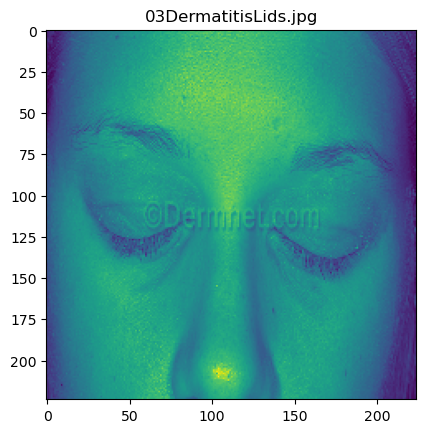

-----------------------------
As imagens no conjunto de teste não estão em escala de cinza.


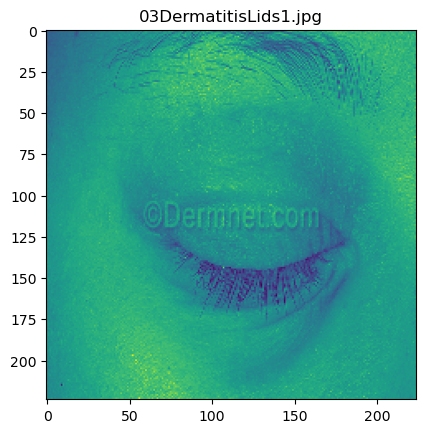

In [11]:
# Dimensionality reduction (Grayscale Conversion)
def grayscale_conversion(images):
    grayscale_images = []
    for img in images:
        img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(img_grayscale)
    return np.array(grayscale_images)

# Converter para uma escala de cinza as imagens de treinamento e teste
train_images_grayscale = grayscale_conversion(train_images_array)
test_images_grayscale = grayscale_conversion(test_images_array)

# Verificar as imagens de treino em escala de cinza
canais_train = train_images_grayscale[0].shape[-1]  # Obtém a última dimensão, que representa os canais de cor
print("As imagens no conjunto de treino estão em escala de cinza." if canais_train == 1 else "As imagens no conjunto de treino não estão em escala de cinza.")
see_plt(train_names[0], train_images_grayscale[0])
see_cv2("treino",train_images_grayscale[0])
print("-----------------------------")
# Verificar as imagens de teste em escala de cinza
canais_test = test_images_grayscale[0].shape[-1]  # Obtém a última dimensão, que representa os canais de cor
print("As imagens no conjunto de teste estão em escala de cinza." if canais_test == 1 else "As imagens no conjunto de teste não estão em escala de cinza.")
see_plt(test_names[1], test_images_grayscale[1])
see_cv2("teste",test_images_grayscale[1], True)

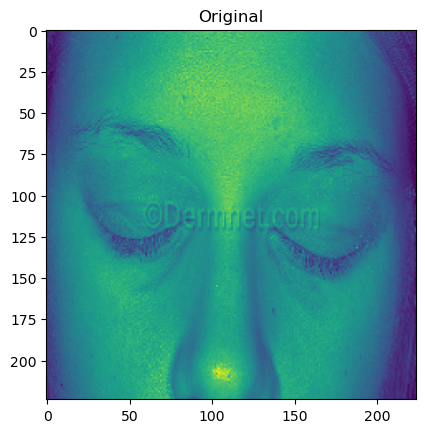

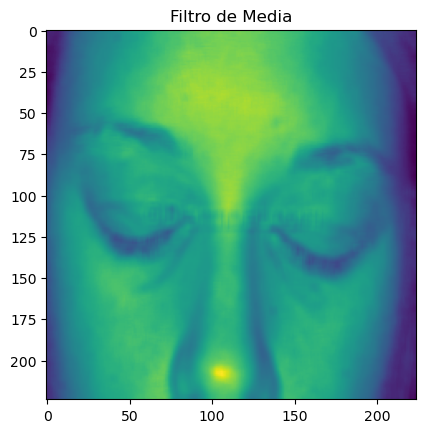

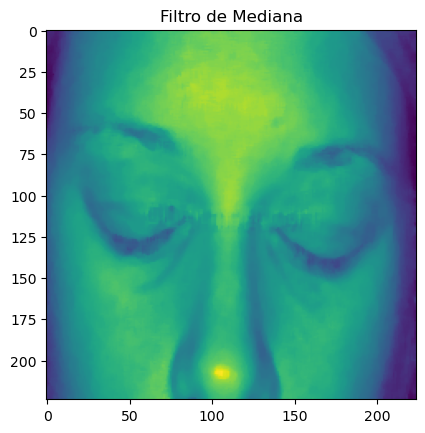

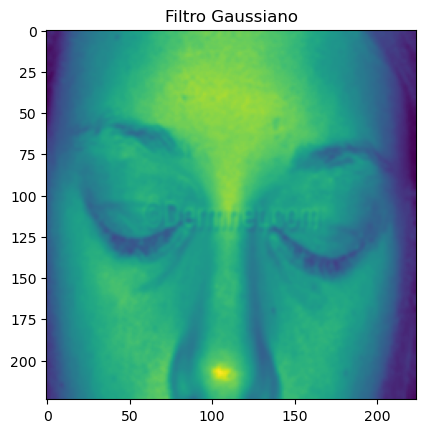

In [12]:
# Filtros de cor
def see_filters(img):
    title="Original"
    see_cv2(title,img)
    see_plt(title,img)
    # Filtro de Média
    media = cv2.blur(img, (5, 5))  # Aplica um filtro de média 5x5
    title="Filtro de Media"
    see_cv2(title,media)
    see_plt(title,media)
    #Filtro de Mediana
    mediana = cv2.medianBlur(img, 5)  # Aplica um filtro de mediana 5x5
    title="Filtro de Mediana"
    see_cv2(title,mediana)
    see_plt(title,mediana)
    # Filtro Gaussiano
    gaussiano = cv2.GaussianBlur(img, (5, 5), 0)  # Aplica um filtro Gaussiano 5x5
    title="Filtro Gaussiano"
    see_cv2(title,gaussiano,True)
    see_plt(title,gaussiano)

see_filters(train_images_grayscale[0])

## 1.6 Normalização

Transformação de cada instancia para um intervalo especifico: [0,1]. 

In [16]:
# Normalização
def normalize_images(images):
    normalized_images = []
    for img in images:
        normalized_img = img / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]
        normalized_images.append(normalized_img)
    return np.array(normalized_images)

# Normalizar imagens de treinamento e teste
train_images_normalized = normalize_images(train_images_resized)
print(f"Imagens do treino normalizadas concluidas...")
test_images_normalized = normalize_images(test_images_resized)
print(f"Imagens do teste normalizadas concluidas...")


Imagens do treino normalizadas concluidas...
Imagens do teste normalizadas concluidas...


## 1.7 Augmentation
Criação de novos exemplos de treino, nomeadamente imagens atravês de simples transformações: 
- `rotation_range`: Define o intervalo de ângulos nos quais as imagens podem ser rotacionadas aleatoriamente.
- `width_shift_range`: Especifica a faixa (em fração da largura total da imagem) na qual a imagem pode ser deslocada horizontalmente.
- `height_shift_range`: Especifica a faixa (em fração da altura total da imagem) na qual a imagem pode ser deslocada verticalmente.
- `zoom_range`: Define a faixa para aplicar zoom aleatório nas imagens.
- `horizontal_flip`: Booleano que indica se as imagens devem ser viradas horizontalmente aleatoriamente.
- `brightness_range`: Intervalo que define a faixa de ajuste de brilho para as imagens.


In [17]:
#Augmentation
# Criar um gerador de imagens com técnicas de aumento de dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Redimensionar imagens para o formato esperado pelo ImageDataGenerator
#train_images_augmented = train_images_normalized.reshape(-1, new_size[0], new_size[1], 3)

# Ajustar o gerador às imagens de treinamento
#datagen.fit(train_images_augmented)

## 1.8 Balanceamento dos dados

Para balancear as classes existentes implementamos o Random Over Sampler, este aumenta artificialmente o número de exemplos nas classes minoritárias.


In [19]:
# Balanceamento de classes

train_labels = [
    "Lupus and other Connective Tissue diseases",
    "Atopic Dermatitis Photos",
    "Melanoma Skin Cancer Nevi and Moles",
    "Psoriasis pictures Lichen Planus and related diseases",
    "Urticaria Hives"
]

# Converter labels para números inteiros
label_to_integer = {label: idx for idx, label in enumerate(train_labels)}
train_labels_int = [label_to_integer[label] for label in train_labels]

# Aplicar oversampling
oversampler = RandomOverSampler()
train_images_balanced, train_labels_balanced = oversampler.fit_resample(train_images_normalized.reshape(len(train_images_normalized), -1), train_labels_int)

print(f"Balanceamento das classes concluido.")


Balanceamento das classes concluido.


In [20]:
# Contagem de instâncias por classe antes do balanceamento
counter_before = Counter(train_labels)
print("Contagem de instâncias por classe antes do balanceamento:", counter_before)
print("-------------------------------------")
# Contagem de instâncias por classe depois do balanceamento
counter_after = Counter(train_labels_balanced)
print("Contagem de instâncias por classe depois do balanceamento:", counter_after)


Contagem de instâncias por classe antes do balanceamento: Counter({'Lupus and other Connective Tissue diseases': 1, 'Atopic Dermatitis Photos': 1, 'Melanoma Skin Cancer Nevi and Moles': 1, 'Psoriasis pictures Lichen Planus and related diseases': 1, 'Urticaria Hives': 1})
-------------------------------------
Contagem de instâncias por classe depois do balanceamento: Counter({0: 1, 1: 1, 2: 1, 3: 1, 4: 1})


In [21]:
# Verificar os rótulos únicos antes do balanceamento em train_labels 
unique_labels = np.unique(train_labels)
print("Rótulos únicos antes do balanceamento:", unique_labels)

print("-------------------------------------")

# Verificar os rótulos únicos depois do balanceamento em train_labels_balanced
unique_labels_balanced = np.unique(train_labels_balanced)
print("Rótulos únicos depois do balanceamento:", unique_labels_balanced)


Rótulos únicos antes do balanceamento: ['Atopic Dermatitis Photos' 'Lupus and other Connective Tissue diseases'
 'Melanoma Skin Cancer Nevi and Moles'
 'Psoriasis pictures Lichen Planus and related diseases' 'Urticaria Hives']
-------------------------------------
Rótulos únicos depois do balanceamento: [0 1 2 3 4]


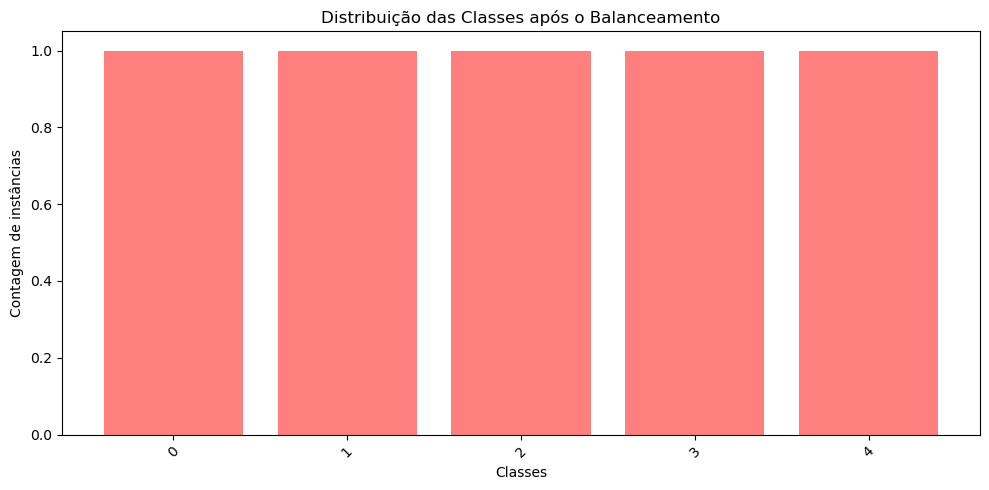

In [23]:
# Contagem de instâncias por classe depois do balanceamento
counter_after = Counter(train_labels_balanced)
labels_after, counts_after = zip(*sorted(counter_after.items()))  # Ordenando os rótulos e contagens

# Gráfico de barras depois do balanceamento
plt.figure(figsize=(10, 5))
plt.bar(labels_after, counts_after, color='red', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Contagem de instâncias')
plt.title('Distribuição das Classes após o Balanceamento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardar os novos dados
Após o pre-processamento estar concluido guardar a nova instancia dos dados para posteriormente utiliza-los para treinar diferentes modelos 

In [58]:
# Guardar o data-set pre-processado
# Guardar imagens pré-processadas e rótulos em arquivos NumPy

#np.save('train_images.npy', train_images_balanced)
#np.save('train_labels.npy', train_labels_balanced)
#np.save('test_images.npy', test_images_normalized)
#np.save('test_labels.npy', test_labels)